In [1]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import json
import matplotlib.pyplot as plt
import numpy as np
import pystan
import random
import seaborn as sns 
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [13]:
baseline="""

data {
      int<lower=1> I; // number of products
      int<lower=1> N; // number of reviews
      int<lower=1> J; // number of reviewers
      vector<lower=0> [N] scores; // review scores vector
      int reviewerID[N]; // reviewer ID for each review
      int prodID[N]; // product ID for each review
}

parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}

model {
    c ~ gamma(1,1);
    truescore ~ normal(3,1); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]] + reviewbias[reviewerID[i]], 1);
        } 
    }

"""

In [14]:
model1="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(3,1); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
       scores[i] ~ normal(truescore[prodID[i]]+ reviewbias[reviewerID[i]], 1/d);
    }
}

"""

In [40]:
model2="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    vector<lower=0> [N] sentscore; // review sentiment score 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(4.11,1.26); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]]+reviewbias[reviewerID[i]], 1/((sentscore[i])*d));
} 
}
"""

In [ ]:
model3="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    vector<lower=0> [N] helpfulness; // helpfulness score 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(4.11,1.26); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]]+reviewbias[reviewerID[i]], 1/((1+helpfulness[i])*d));
} 
}
"""

In [16]:
model4="""
data {
    int<lower=1> I; // number of products
    int<lower=1> N; // number of reviews
    int<lower=1> J; // number of reviewers
    vector<lower=0> [N] scores; // review scores vector 
    vector<lower=0> [N] helpfulness; // helpfulness score 
    int reviewerID[N]; // reviewer ID for each review
    int prodID[N]; // product ID for each review
}
parameters {
    vector [I] truescore;
    vector [J] reviewbias;
    real<lower=0> c;
    real<lower=0> d;
}
model {
    c ~ gamma(1,1);
    d ~ gamma(1,1);
    truescore ~ normal(4.11,1.26); // TODO: change hyperparameters for data 
    reviewbias ~ normal(0, 1/c);
    for (i in 1:N) {
        scores[i] ~ normal(truescore[prodID[i]]+reviewbias[reviewerID[i]], 1/d);
} 
}
"""

In [6]:
def plot_bias(rusers,fit_df):
    reviewers = len(rusers)
    rb_ind = []
    for i in range(20):
        rb_num = random.randint(1,reviewers)
        while rb_num in rb_ind:
            rb_num = random.randint(1,reviewers)
        str_ind = "reviewbias["+str(rb_num)+']'
        reviewer_bias_ind_plt = fit_df[str_ind]   
        rb_ind.append(rb_num)        
        plt.subplots(figsize=(15,3))
        plt.subplot(1,4,1)
        sns.kdeplot(reviewer_bias_ind_plt)
    return

In [23]:
def plot_goodness(rproducts,fit_df):
    prod = len(rproducts)
    prod_ind = []
    for i in range(20):
        prod_num = random.randint(1,prod)
        while prod_num in prod_ind:
            prod_num = random.randint(1,prod)
        str_ind = "truescore["+str(prod_num)+']'
        prod_ind_plt = fit_df[str_ind]   
        prod_ind.append(prod_num)        
        plt.subplots(figsize=(15,3))
        plt.subplot(1,4,1)
        sns.kdeplot(prod_ind_plt)
    return

In [8]:
def sentiment_analyzer_scores(analyser,sentence):
    score = analyser.polarity_scores(sentence)
    cscore=score['compound']
    inputlow=-1
    inputhigh=1
    outputlow=1
    outputhigh=5
    cscore=((cscore-inputlow)/(inputhigh-inputlow))*(outputhigh-outputlow)+outputlow
    return cscore
    
#     Result := ((Input - InputLow) / (InputHigh - InputLow))
#           * (OutputHigh - OutputLow) + OutputLow;

def getSentimentScore(review):
    analyser = SentimentIntensityAnalyzer()
    score=sentiment_analyzer_scores(analyser,review)
    return score

def getReviewQuality(rating,sscore):
    
    rq=1/(abs(rating-sscore)+1e-3)
    inputlow=1/(4+1e-3)
    inputhigh=1/(1e-3)
    outputlow=1
    outputhigh=2
    rp=((rq-inputlow)/(inputhigh-inputlow))*(outputhigh-outputlow)+outputlow
    print(str(rq)+" "+str(abs(rating-sscore))+" "+str(rp))
    return rp

In [34]:
path='reviews_Amazon_Instant_Video_5.json'

data=[]
for line in open(path,'r'):
    data.append(json.loads(line))

products={}
for d in data:
    if d['asin'] not in products:
        products[d['asin']] = [d]
    else:
        products[d['asin']].append(d)

users={}
for d in data:
    if d['reviewerID'] not in users:
        users[d['reviewerID']] = [d]
    else:
        users[d['reviewerID']].append(d)

print('No of reviews',len(data))   
print('No of reviewers',len(users))  
print('No. of products reviewed',len(products.keys()))

count1=0
rusers={}
for key in users.keys():
    
    if len(users[key])>10:
        pr=[]
        diff=0
        for i in users[key]:
            if i['asin'] not in pr:
                pr.append(i['asin'])
            else:
                diff+=1
        if(len(users[key])-diff>10):
            count1+=1
            rusers[key]=users[key]
                
print('No of users with more than 10 reviews',count1)

count2=0
rproducts={}
for key in products.keys():
    
    if len(products[key])>10:
        ur=[]
        diff=0
        for i in products[key]:
            if i['reviewerID'] not in ur:
                ur.append(i['reviewerID'])
            else:
                diff+=1
        if(len(products[key])-diff>10):
            count2+=1
            rproducts[key]=products[key]


print('No of products with more than 10 reviews',count2)

print("Reduced users",len(rusers))
print("Reduced products",len(rproducts))


rmap={}
pmap={}
rcount=1
pcount=1

for key in rusers.keys():
    rmap[key]=rcount
    rcount+=1

for key in rproducts.keys():
    pmap[key]=pcount
    pcount+=1


reviewer=[]
product=[]
ratings=[]
helpful=[]
reviewQuality=[]
reviewText=[]
sent_score=[]

for key in rusers.keys():
    for prod in rusers[key]:
        
        if prod['asin'] in rproducts:
            reviewer.append(rmap[key])
            product.append(pmap[prod['asin']])
            ratings.append(prod['overall'])
            s_score=getSentimentScore(prod['reviewText'])
            sent_score.append(s_score)
            rq=getReviewQuality(prod['overall'],s_score)
            reviewQuality.append(rq)
            reviewText.append(prod['reviewText'])
            hrating=prod['helpful'][0]+prod['helpful'][1]
            if hrating==0:
                hrating=0
            else:
                hrating=prod['helpful'][0]/hrating
            helpful.append(hrating+1)
            
d=[reviewer,product,ratings,helpful,reviewQuality,reviewText]

ind=[]
for i in range(len(d[0])):
    ind.append(i)
random.shuffle(ind)

sdata=[[],[],[],[],[],[]]
for i in ind:
    for j in range(len(sdata)):
        sdata[j].append(d[j][i])

prod=set()
for p in sdata[1]:
    prod.add(p)
print(len(prod))
training_data=[sdata[0][:5000],sdata[1][:5000],sdata[2][:5000],sdata[3][:5000],sdata[4][:5000],sdata[5][:5000]]
test_data=[sdata[0][5000:],sdata[1][5000:],sdata[2][5000:],sdata[3][5000:],sdata[4][5000:],sdata[5][5000:]]
train_users=set()
for t in training_data[0]:
    train_users.add(t)
print(len(train_users))

train_products=set()
for p in training_data[1]:
    train_products.add(p)
print(len(train_products))
#print(training_data[4])

No of reviews 37126
No of reviewers 5130
No. of products reviewed 1685
No of users with more than 10 reviews 511
No of products with more than 10 reviews 810
Reduced users 511
Reduced products 810
0.39840637450199207 2.509 1.0001485059760957
3.711952487008167 0.26839999999999997 1.00346288047513
6.273525721455446 0.15840000000000032 1.0060250941028859
6.273525721455446 0.15840000000000032 1.0060250941028859
1.0841283607979182 0.9214000000000002 1.000834399392888
0.27584684982897495 3.6242 1.0000259158115414
1.3683634373289546 0.7298 1.0011187055281883
0.3954132068011072 2.528 1.0001455120601028
59.52380952380782 0.01580000000000048 1.0592886904761887
23.474178403755946 0.04159999999999986 1.0232300469483568
1.0218679746576744 0.9775999999999998 1.0007721234416513
1.0528532322594226 0.9488000000000003 1.0008031164455675
20.920502092050132 0.046800000000000175 1.0206757322175732
1.1312217194570136 0.883 1.000881504524887
0.2563445270443476 3.9 1.0000064086131761
0.5072537283149032 1.9703

1.864975755315182 0.5351999999999997 1.001615441999254
0.5415357955160837 1.8456000000000001 1.000291671179465
1.0883761427949503 0.9177999999999997 1.0008386482368306
6.2972292191435795 0.15779999999999994 1.0060488035264483
1.1646866992778946 0.8575999999999997 1.0009149778709527
2.1958717610891516 0.45440000000000014 1.0019464207290294
37.59398496240623 0.025599999999999845 1.0373533834586468
2.3148148148148144 0.43100000000000005 1.0020653935185184
0.516049127876974 1.9367999999999999 1.000266178140159
0.5230125523012553 1.9109999999999996 1.0002731433054393
0.5387931034482759 1.855 1.0002889278017242
1.0862480990658268 0.9196 1.0008365196610907
29.069767441860197 0.03340000000000032 1.0288270348837207
75.75757575757582 0.012199999999999989 1.0755265151515152
40.983606557376156 0.02340000000000053 1.0407438524590156
1.0078613182826042 0.9912000000000001 1.000758113283612
28.248587570621655 0.034399999999999764 1.0280056497175143
178.57142857143057 0.0045999999999999375 1.1783660714

11.961722488038244 0.08260000000000023 1.0117147129186603
1.041232819658475 0.9594000000000005 1.0007914931278634
192.307692307693 0.0041999999999999815 1.19210576923077
1.09217999126256 0.9146000000000001 1.0008424530362603
1.1470520761642578 0.8708 1.0008973388391833
1.0072522159548756 0.9917999999999996 1.0007575040290089
0.5098399102681759 1.9604 1.0002599673702457
29.940119760479057 0.032399999999999984 1.0296976047904192
8.896797153024933 0.11139999999999972 1.0086490213523132
1.0038144950813084 0.9952000000000005 1.000754065448705
60.97560975609891 0.015399999999999636 1.0607408536585379
1.0181225819588675 0.9812000000000003 1.0007683771126044
22.72727272727265 0.04300000000000015 1.0224829545454546
1.0414496979795875 0.9592 1.000791710060404
24.50980392156886 0.03979999999999961 1.0242659313725493
3.2258064516129017 0.30900000000000016 1.0029766129032258
1.064509261230573 0.9383999999999997 1.000814775388546
63.29113924050574 0.014800000000000146 1.0630569620253159
12.048192771

2.5138260432378092 0.3967999999999998 1.0022644544997485
2.723311546840958 0.3662000000000001 1.0024739923747277
0.44927666457004223 2.2248 1.0001993889837362
0.7370283018867926 1.3558 1.0004872125589623
1.7642907551164428 0.5658000000000001 1.0015147318278053
0.3688947912055482 2.7098 1.0001189870149034
1.3071895424836601 0.764 1.0010575163398694
5.370569280343716 0.18520000000000003 1.0051219119226638
2.9603315571343973 0.3368000000000002 1.0027110716400236
2.0798668885191347 0.4798 1.0018303868552412
0.49975012493753124 2.0 1.0002498750624689
1.3751375137513744 0.7262000000000004 1.0011254812981298
6.657789613848183 0.14920000000000044 1.0064094540612516
1.1223344556677894 0.8899999999999997 1.0008726150392817
3.4129692832764524 0.2919999999999998 1.0031638225255972
3.5765379113018603 0.27859999999999996 1.0033274320457797
0.3280624630929729 3.0472 1.0000781444787088
1.6281341582546403 0.6132 1.0013785411917941
9.157509157509152 0.10820000000000007 1.0089097985347986
33.112582781457

3.3534540576794085 0.29720000000000013 1.003104292421194
0.49975012493753124 2.0 1.0002498750624689
2.236135957066189 0.44620000000000015 1.0019866949910554
2.250225022502248 0.44340000000000046 1.0020007875787578
2.801120448179273 0.35599999999999987 1.0025518207282913
0.6844626967830254 1.46 1.0004346338124572
0.4545867806164196 2.1988000000000003 1.0002047004273116
2.2914757103574703 0.4354 1.0020420485792851
0.3345824411134904 2.9878 1.0000846660867238
0.7061149555147579 1.4152 1.0004562914842536
2.871912693854107 0.34719999999999995 1.0026226306720276
0.8499065102838687 1.1756000000000002 1.0006001189869114
1.1856770215793218 0.8424 1.0009359734408347
1.189060642092747 0.8399999999999999 1.0009393579072532
0.47952431188261235 2.0844000000000005 1.0002296441929606
0.5089058524173027 1.9640000000000004 1.0002590330788803
1.8939393939393934 0.5270000000000001 1.0016444128787878
1.332267519317879 0.7496 1.0010826005861977
0.6339546088500065 1.5763999999999996 1.0003841130975022
4.9358

0.30665440049064707 3.26 1.0000567310640909
1.3774104683195598 0.7249999999999996 1.0011277548209367
3.3579583613163178 0.2968000000000002 1.0031087978509066
1.3422818791946314 0.7439999999999998 1.0010926174496644
0.7134703196347032 1.4006 1.0004636486872147
6.43500643500644 0.15439999999999987 1.0061866151866152
0.4368338284116723 2.2882 1.0001869430368688
0.907770515613653 1.1006 1.0006579974582426
0.2501125506477915 3.9972000000000003 1.0000001750787855
0.254220052877771 3.9326 1.000004283607891
0.25100401606425704 3.983 1.0000010667670682
0.2501626056937009 3.9964 1.0000002251463451
36.496350364963824 0.026399999999999757 1.0362554744525552
0.250363026388263 3.9932 1.0000004256171449
0.25035049068696175 3.9934000000000003 1.0000004130783096
0.3617159806120234 2.7636000000000003 1.0001118064096073
0.2511426992817319 3.9808 1.0000012054849565
0.3351431061063074 2.9828 1.0000852268918827
1.0233319688907077 0.9762000000000004 1.0007735878018829
26.737967914438194 0.03640000000000043 1

11.037527593818997 0.0895999999999999 1.0107902869757175
3.5014005602240874 0.2846000000000002 1.0032522759103641
3.3944331296673496 0.29359999999999964 1.0031452817379498
1.9952114924181983 0.5001999999999995 1.0017457102952914
3.346720214190088 0.2978000000000005 1.0030975568942437
0.7328154770628756 1.3636 1.000482998680932
0.7570022710068132 1.3199999999999998 1.0005071915215746
5.263157894736841 0.18900000000000006 1.0050144736842106
7.974481658692209 0.12439999999999962 1.0077264752791069
6.535947712418295 0.15200000000000014 1.0062875816993464
5.235602094240852 0.1899999999999995 1.0049869109947644
0.5618608832453085 1.7788 1.000312001348466
1.464128843338213 0.6820000000000004 1.001214494875549
2.4838549428713352 0.4016000000000002 1.002234475906607
1.0477787091366302 0.9534000000000002 1.000798040653814
8.319467554076526 0.1192000000000002 1.008071547420965
1.5151515151515156 0.6589999999999998 1.0012655303030302
2.8089887640449405 0.3550000000000004 1.002559691011236
0.350311

0.5129783523135324 1.9484 1.0002631065969017
10.330578512396634 0.09580000000000055 1.0100831611570247
0.2743935901657338 3.6433999999999997 1.0000244621885632
1.1778563015312133 0.8479999999999999 1.0009281507656067
2.19876868953386 0.4538000000000002 1.0019493183817063
1.8839487565938213 0.5297999999999998 1.001634419743783
0.9869719699960522 1.0122 1.0007372187129886
8.319467554076526 0.1192000000000002 1.008071547420965
0.8058017727639 1.2400000000000002 1.000556003223207
0.27763895829862845 3.6008 1.0000277083680382
2.2696323195642285 0.43960000000000043 1.0020201997276441
0.26595744680851063 3.759 1.0000160239361702
0.32094486167276465 3.1148 1.0000710250978881
0.30396984619125783 3.2888 1.0000540458386529
8.130081300813016 0.12199999999999989 1.0078821138211382
1.0907504363001745 0.9158 1.0008410231239093
0.25302363240726683 3.9512 1.0000030868883154
0.6264094211976948 1.5954000000000002 1.000376566023553
20.83333333333346 0.04699999999999971 1.0205885416666667
0.256858111579163

0.37299515106303616 2.68 1.0001230883998509
0.4199563245422476 2.3802 1.0001700613136233
1.7307026652821034 0.5768000000000004 1.0014811353409485
4.516711833785011 0.2203999999999997 1.0042678410117434
3.531073446327689 0.28219999999999956 1.0032819562146893
0.49975012493753124 2.0 1.0002498750624689
1.9523623584537269 0.5112000000000005 1.0017028504490433
1.6767270288397058 0.5953999999999997 1.0014271462105968
14.24501424501417 0.06920000000000037 1.0139985754985754
1.1665888940737281 0.8562000000000003 1.0009168805412973
0.5181347150259067 1.9290000000000003 1.0002682642487046
1.0803802938634401 0.9245999999999999 1.0008306503889368
0.25588536335721596 3.907 1.000005949334698
1.1967448539971277 0.8346 1.0009470440402106
1.1728829462819619 0.8515999999999995 1.0009231761670185
0.5214308061320262 1.9168000000000003 1.0002715611638335
1.1047282368537341 0.9041999999999999 1.0008550044189128
0.5294927459493806 1.8876 1.000279625119136
0.4395990856339019 2.2738 1.0001897089854053
0.52559

6.265664160401008 0.15859999999999985 1.0060172305764412
1.2465719272001998 0.8011999999999997 1.000996883570182
0.9846396218983856 1.0145999999999997 1.000734885781804
3.5435861091424505 0.2812000000000001 1.0032944720056698
3.0395136778115472 0.3280000000000003 1.002790273556231
0.546806649168854 1.8277999999999999 1.000296943350831
4.139072847682124 0.2405999999999997 1.0038901076158941
2.185314685314686 0.4565999999999999 1.001935861013986
0.3890747801727492 2.5692 1.0001391720488677
0.5569169079973268 1.7946 1.0003070561372243
9.174311926605458 0.10800000000000054 1.0089266055045871
1.4168319637291007 0.7048000000000005 1.00116718617172
1.0559662090813098 0.9459999999999997 1.0008062302006335
21.645021645021895 0.04519999999999946 1.0214004329004331
1.5639662183296845 0.6383999999999999 1.0013143572098844
2.247191011235955 0.44399999999999995 1.0019977528089887
0.5195344970906068 1.9238 1.000269664380715
6.393861892583112 0.1554000000000002 1.0061454603580562
6.218905472636827 0.1

3.469812630117975 0.2871999999999999 1.0032206800832755
1.2674271229404306 0.7880000000000003 1.0010177439797212
0.544425087108014 1.8358 1.0002945611933798
0.5870611717740989 1.7024 1.0003372079370672
49.01960784313705 0.019400000000000084 1.0487818627450978
0.34928396786587496 2.862 1.000099371288858
0.6200396825396827 1.6117999999999997 1.0003701946924604
0.5773672055427251 1.731 1.000327511547344
1.6633399866932799 0.6002000000000001 1.00141375582169
0.562429696287964 1.7770000000000001 1.0003125703037121
1.538935056940597 0.6488 1.001289319790705
0.5665080444142307 1.7642 1.0003166496714253
1.3312034078807242 0.7502 1.0010815362087326
0.5204538357447694 1.9204 1.0002705839492037
2.3640661938534295 0.4219999999999997 1.0021146572104018
0.3568624652059097 2.8011999999999997 1.0001069516808223
0.3375869286341233 2.9612 1.0000876713253664
1.1013215859030836 0.907 1.0008515969162997
0.6115459882583171 1.6342 1.0003616988747555
1.492982979994028 0.6688000000000001 1.001243356225739
1.69

0.5404821100421577 1.8491999999999997 1.0002906172305697
0.5004504053648283 1.9972000000000003 1.0002505755179663
0.34635633139373784 2.8862000000000005 1.0000964429204766
1.0076582023377665 0.9914000000000005 1.0007579101168884
1.0759629868732516 0.9283999999999999 1.00082623197762
0.5082850462539392 1.9664000000000001 1.0002584121175155
7.987220447284339 0.12420000000000009 1.0077392172523962
0.8732099196646878 1.1441999999999997 1.0006234282221447
1.2540757461750687 0.7964000000000002 1.0010043892651117
0.6320313487548983 1.5812 1.000382189356592
1.5639662183296845 0.6383999999999999 1.0013143572098844
1.8559762435040836 0.5377999999999998 1.001606440237565
14.326647564470012 0.06879999999999953 1.014080229226361
1.8484288354898335 0.54 1.0015988909426987
5.291005291005299 0.18799999999999972 1.005042328042328
12.78772378516625 0.07719999999999994 1.0125409207161125
2.5786487880350695 0.38680000000000003 1.0023292934502321
8.27814569536426 0.11979999999999968 1.0080302152317882
0.31

1.2481278082875682 0.8002000000000002 1.0009984398402396
6.5876152832674455 0.15080000000000027 1.0063392621870884
7.473841554559066 0.13279999999999959 1.0072257100149478
1.8796992481203019 0.5309999999999997 1.0016301691729323
2.4975024975024978 0.3994 1.002248126873127
1.5499070055796649 0.6442000000000001 1.001300294482331
2.393489707994254 0.4168000000000003 1.0021440880804213
5.807200929152155 0.1711999999999998 1.0055586527293845
7.6335877862595485 0.1299999999999999 1.007385496183206
6.218905472636809 0.15980000000000016 1.005970460199005
1.9098548510313227 0.5225999999999997 1.0016603323147442
16.28664495114018 0.060399999999999565 1.016040716612378
0.42430414120841825 2.3558 1.0001744102172436
2.123142250530787 0.46999999999999975 1.0018736730360933
3.799392097264438 0.2622 1.0035503419452887
1.588814744200826 0.6284000000000001 1.0013392119478868
0.907770515613653 1.1006 1.0006579974582426
3.369272237196767 0.29579999999999984 1.003120114555256
1.020616452337212 0.9787999999

1.4351320321469572 0.6958000000000002 1.001185490815155
0.39984006397441024 2.5 1.0001499400239904
0.2890006358013988 3.4592 1.0000390728859603
1.1918951132300357 0.8380000000000001 1.0009421930870084
18.726591760299467 0.052400000000000446 1.0184812734082396
1.041232819658475 0.9594000000000005 1.0007914931278634
21.92982456140352 0.04459999999999997 1.0216853070175438
5.005005005004997 0.1988000000000003 1.0047562562562562
28.901734104046366 0.03359999999999985 1.0286589595375724
17.92114695340496 0.05480000000000018 1.0176756272401433
1.0590976488032195 0.9432 1.0008093624232155
0.5249895002099958 1.9038 1.000275120747585
1.1518083390923746 0.8672000000000004 1.0009020962911772
15.151515151515266 0.0649999999999995 1.0149053030303032
1.0199918400652794 0.9794 1.0007702468380253
1.9149751053236297 0.5212000000000003 1.0016654538490999
20.242914979757085 0.0484 1.019997975708502
5.537098560354382 0.17959999999999976 1.0052884828349944
0.6075334143377886 1.645 1.0003576852976914
0.5038

0.9613535858488752 1.0392000000000001 1.0007115939242452
4.306632213608952 0.2312000000000003 1.0040577088716625
8.741258741258711 0.11340000000000039 1.008493444055944
1.1786892975011787 0.8473999999999999 1.0009289839698257
3.285151116951381 0.3033999999999999 1.0030359724047306
4.566210045662101 0.21799999999999997 1.0043173515981736
1.527183872938301 0.6538000000000004 1.0012775656689066
1.0626992561105213 0.9399999999999995 1.0008129649309245
7.751937984496117 0.1280000000000001 1.0075038759689923
2.2841480127912295 0.43679999999999986 1.0020347190497945
4.557885141294441 0.21839999999999993 1.0043090246125799
1.2465719272001998 0.8011999999999997 1.000996883570182
3.8910505836575875 0.256 1.0036420233463035
5.5309734513274345 0.17979999999999996 1.0052823561946902
2.319109461966605 0.4301999999999999 1.0020696892393322
1.6688918558077435 0.5982000000000001 1.0014193090787717
0.3273965426925092 3.0534 1.0000774783918283
1.2215978499877838 0.8176000000000001 1.0009719032494502
0.26

6.211180124223597 0.16000000000000014 1.0059627329192546
3.188775510204084 0.31259999999999977 1.0029395727040817
5.279831045406556 0.18839999999999968 1.005031151003168
2.5893319523562908 0.3852000000000002 1.0023399792853445
0.9521995810321845 1.0492 1.0007024376309275
7.082152974504244 0.1402000000000001 1.006833923512748
0.5569169079973268 1.7946 1.0003070561372243
4.288164665523161 0.23219999999999974 1.0040392367066895
22.72727272727265 0.04300000000000015 1.0224829545454546
4.844961240310077 0.20540000000000003 1.00459617248062
25.906735751295134 0.0376000000000003 1.025663212435233
15.290519877675838 0.06440000000000001 1.0150443425076452
1.1665888940737281 0.8562000000000003 1.0009168805412973
4.428697962798935 0.2248000000000001 1.0041798051372897
39.37007874015752 0.024399999999999977 1.0391299212598426
19.920318725099637 0.04919999999999991 1.0196752988047808
8.620689655172399 0.11500000000000021 1.0083728448275862
1.9584802193497852 0.5095999999999998 1.0017089698394046
1.

0.9230201218386563 1.0823999999999998 1.0006732508768692
53.191489361701386 0.01780000000000026 1.052954787234042
27.932960893854965 0.03479999999999972 1.0276899441340783
14.00560224089631 0.07040000000000024 1.0137591036414566
0.5066882853668424 1.9726 1.0002568149574382
71.42857142857193 0.0129999999999999 1.071196428571429
43.47826086956476 0.02200000000000024 1.0432391304347821
22.026431718061893 0.04439999999999955 1.0217819383259914
40.32258064516194 0.0237999999999996 1.0400826612903233
0.7608034083992696 1.3134000000000001 1.0005109936092513
1.1770244821092275 0.8486000000000002 1.0009273187382297
16.611295681063208 0.0591999999999997 1.0163654485049836
60.97560975609891 0.015399999999999636 1.0607408536585379
4.906771344455351 0.20279999999999987 1.0046579980372914
19.531249999999908 0.050200000000000244 1.0192861328124998
104.16666666667211 0.008599999999999497 1.1039427083333389
14.00560224089631 0.07040000000000024 1.0137591036414566
217.39130434780284 0.003600000000000491

4.166666666666669 0.23899999999999988 1.0039177083333333
5.2687038988408705 0.18880000000000052 1.0050200210748155
5.586592178770951 0.17799999999999994 1.0053379888268157
8.56164383561643 0.11580000000000013 1.0083137842465753
7.84929356357926 0.1264000000000003 1.0076012558869702
1.113833815994654 0.8967999999999998 1.0008641122744486
0.8348639171814994 1.1968 1.0005850726331609
2.733734281027884 0.3648 1.0024844177145982
0.8635578583765113 1.157 1.000613773747841
1.1200716845878138 0.8917999999999999 1.000870351702509
1.7123287671232872 0.5830000000000002 1.001462756849315
1.1106175033318526 0.8994 1.0008608951577076
0.48044585375228216 2.0804 1.0002305659652158
0.35642999714856005 2.8045999999999998 1.0001065191046479
1.13947128532361 0.8765999999999998 1.000889756153145
0.3569898614879337 2.8002000000000002 1.0001070791089532
0.2861066605630579 3.4942 1.0000361781872282
1.9992003198720507 0.4992000000000001 1.001749700119952
1.1183180496533212 0.8932000000000002 1.0008685976291658

454.54545454548185 0.0011999999999998678 1.4544090909091183
0.4999999999999999 1.9990000000000006 1.000250125
0.5166890565257828 1.9344 1.00026681822879
1.0020040080160322 0.9969999999999999 1.000752254509018
111.11111111111101 0.008000000000000007 1.1108888888888888
1.5110305228165608 0.6608 1.0012614082804472
1.331203407880725 0.7501999999999995 1.0010815362087326
0.35909221488078136 2.7838000000000003 1.0001091819879344
0.3308847859175435 3.0212000000000003 1.000080967507114
1.3835085777531821 0.7218 1.0011338544548976
2.185314685314686 0.4565999999999999 1.001935861013986
3.9714058776807004 0.2507999999999999 1.0037223987291501
5.405405405405401 0.18400000000000016 1.0051567567567568
2.271694684234441 0.4391999999999996 1.0020222626079054
1.1964584828906444 0.8347999999999995 1.0009467575975113
4.89236790606653 0.20340000000000025 1.0046435909980431
19.84126984126971 0.04940000000000033 1.01959623015873
20.746887966804923 0.04720000000000013 1.0205020746887967
1.2856775520699413 0.

3.3760972316002764 0.29519999999999946 1.003126941255908
2.025931928687198 0.4925999999999995 1.0017764384116694
2.449779519843217 0.40719999999999956 1.002200391964723
0.6201935003721161 1.6114000000000002 1.0003703485487472
90.90909090909267 0.009999999999999787 1.0906818181818199
12.04819277108436 0.08199999999999985 1.011801204819277
2.379819133745835 0.4192 1.0021304140885292
81.96721311475343 0.011200000000000099 1.0817377049180321
6.963788300835662 0.14259999999999984 1.0067155292479109
12.853470437017926 0.07680000000000042 1.0126066838046273
0.3768749528906309 2.6524 1.0001269691716288
2.2172949002217286 0.4500000000000002 1.0019678492239468
0.2741979709350151 3.646 1.0000242665204278
0.36400698893418754 2.7462 1.0001140979906815
0.2522704339051463 3.963 1.0000023335015136
0.33561551886159213 2.9786 1.0000856994227414
1.3213530655391124 0.7557999999999998 1.0010716834038056
1.3003901170351109 0.7679999999999998 1.0010507152145645
0.3548867911136348 2.8167999999999997 1.0001049

0.5084918132818061 1.9656000000000002 1.000258618936235
0.6443298969072164 1.5510000000000002 1.0003944909793814
0.539490720759603 1.8525999999999998 1.0002896255934397
0.6477522995206634 1.5428 1.0003979142375956
0.4379434177104318 2.2824 1.000188052903565
6.218905472636827 0.15979999999999972 1.005970460199005
0.9641342074816815 1.0362 1.0007143752410335
15.151515151515266 0.0649999999999995 1.0149053030303032
0.5058680696074466 1.9757999999999996 1.000255994536625
1.025220422390814 0.9744000000000002 1.0007754767274963
0.506380392951185 1.9737999999999998 1.0002565069880494
0.5911563017261765 1.6905999999999999 1.0003413040908016
1.1178180192264697 0.8936000000000002 1.0008680974737312
1.4289797084881397 0.6987999999999999 1.0011793369534152
1.0532968190436065 0.9483999999999999 1.0008035601432483
0.494510928691524 2.0212000000000003 1.0002446345564238
1.0493179433368311 0.952 1.0007995802728227
1.2550200803212854 0.7957999999999998 1.0010053338353413
0.3802570537683474 2.6288 1.000

3.846153846153841 0.25900000000000034 1.0035971153846155
0.6662225183211193 1.5 1.0004163890739508
4.078303425774874 0.2442000000000002 1.0038293230016313
10.660980810234491 0.09280000000000044 1.0104136460554372
4.078303425774874 0.2442000000000002 1.0038293230016313
3.491620111731842 0.2854000000000001 1.0032424930167598
1.8274853801169597 0.5461999999999998 1.001577942251462
0.31798524548460955 3.1437999999999997 1.0000680647417959
13.661202185792341 0.07220000000000004 1.0134146174863388
1000.0 0.0 2.0
1.3422818791946314 0.7439999999999998 1.0010926174496644
0.9990009990009991 1.0 1.0007492507492508
2.379819133745835 0.4192 1.0021304140885292
1.463271875914546 0.6823999999999995 1.0012136376938836
10.5263157894737 0.09399999999999986 1.010278947368421
1.634521085322 0.6108000000000002 1.0013849297155932
2.2441651705565513 0.44460000000000033 1.0019947262118492
9.615384615384638 0.10299999999999976 1.0093677884615384
2.7578599007170426 0.36160000000000014 1.0025085493656922
555.5555

3.793626707132019 0.26259999999999994 1.0035445751138088
0.6495193556767993 1.5385999999999997 1.0003996817355156
2.8264556246466914 0.3528000000000002 1.0025771622385529
0.31806615776081426 3.143 1.0000681456743004
6.711409395973169 0.1479999999999997 1.0064630872483222
0.5595970900951317 1.7859999999999996 1.0003097369893676
0.4639510067736847 2.1544 1.0002140669945254
6.9060773480663125 0.1437999999999997 1.0066578038674032
1.6772895001677284 0.5952000000000002 1.0014277088225427
0.5569169079973268 1.7946 1.0003070561372243
5.847953216374272 0.16999999999999993 1.0055994152046783
1.9069412662090004 0.5234000000000001 1.0016574180015256
12.376237623762293 0.07980000000000054 1.0121293316831683
6.729475100942139 0.14759999999999973 1.0064811574697174
1.867762420620098 0.5343999999999998 1.0016182293612252
1.1665888940737281 0.8562000000000003 1.0009168805412973
1.2465719272001998 0.8011999999999997 1.000996883570182
1.8395879323031634 0.5426000000000002 1.0015900478292863
4.6816479400

0.590249085113918 1.6932 1.0003403966473852
54.34782608695562 0.017400000000000304 1.0541114130434774
99.99999999999658 0.009000000000000341 1.0997749999999966
11.185682326621919 0.08840000000000003 1.0109384787472036
1.3702384214853391 0.7287999999999997 1.0011205809810908
138.8888888888935 0.006199999999999761 1.1386736111111158
104.16666666667211 0.008599999999999497 1.1039427083333389
73.52941176470618 0.012599999999999945 1.0732977941176474
6.281407035175883 0.1581999999999999 1.0060329773869348
113.63636363636898 0.007799999999999585 1.113414772727278
1.0477787091366302 0.9534000000000002 1.000798040653814
37.03703703703731 0.0259999999999998 1.0367962962962967
1.0369141435089175 0.9634 1.0007871733720448
4.173622704507514 0.23859999999999992 1.0039246661101837
58.139534883722455 0.016199999999999548 1.0579040697674433
7.739938080495377 0.12819999999999965 1.0074918730650155
9.328358208955198 0.1062000000000003 1.0090806902985074
3.8850038850038824 0.2564000000000002 1.0036359751

3.192848020434229 0.3121999999999998 1.0029436462324393
25.38071065989834 0.03840000000000021 1.0251370558375634
12.01923076923073 0.08220000000000027 1.011772235576923
19.60784313725497 0.04999999999999982 1.0193627450980394
10.869565217391282 0.09100000000000019 1.0106222826086957
0.5269259142164613 1.8967999999999998 1.000277057645695
10.37344398340252 0.09539999999999971 1.0101260373443983
1.0608953957139824 0.9416000000000002 1.0008111606195629
0.5696058327637276 1.7546 1.0003197482342219
0.5836348780203107 1.7123999999999997 1.0003337807867398
1.017708121310808 0.9816000000000003 1.0007679625483412
1.0123506782749547 0.9867999999999997 1.0007626037659445
35.71428571428554 0.027000000000000135 1.0354732142857141
0.6838074398249452 1.4614000000000003 1.000433978391685
0.5003001801080649 1.9977999999999998 1.0002504252551532
1.0464629552113853 0.9546000000000001 1.0007967245709501
0.5003001801080649 1.9977999999999998 1.0002504252551532
3.198976327575173 0.3116000000000003 1.0029497

2.503755633450172 0.39840000000000053 1.0022543815723586
5.73394495412844 0.1734 1.005485378440367
0.583158385817588 1.7138 1.000333304175414
1.2481278082875682 0.8002000000000002 1.0009984398402396
4.166666666666669 0.23899999999999988 1.0039177083333333
16.02564102564105 0.0613999999999999 1.0157796474358975
18.382352941176507 0.05339999999999989 1.0181369485294118
161.29032258063697 0.0052000000000003155 1.161080645161282
1.3594344752582928 0.7345999999999999 1.001109774333877
1.919385796545107 0.5199999999999996 1.0016698656429943
1.1296882060551288 0.8842000000000001 1.0008799706281066
1.9880715705765417 0.5019999999999998 1.0017385685884692
24.75247524752442 0.039400000000000546 1.0245086633663363
0.35290796160361376 2.8326000000000002 1.000102996188594
57.47126436781619 0.01639999999999997 1.0572356321839083
0.5111429155591903 1.9554 1.0002612707012881
0.3421845058855735 2.9214 1.000092270052012
2.004008016032063 0.4980000000000002 1.001754509018036
1.2553351744915888 0.79560000

1.8368846436443789 0.5434000000000001 1.0015873438648053
2.449779519843217 0.40719999999999956 1.002200391964723
5.787037037037031 0.17180000000000017 1.0055384837962964
1.331203407880725 0.7501999999999995 1.0010815362087326
2.444987775061128 0.4079999999999995 1.0021955990220048
1.1088933244621864 0.9008000000000003 1.0008591705477934
1.5639662183296845 0.6383999999999999 1.0013143572098844
2.1542438604049954 0.4632000000000005 1.00190478242137
1.3379716350013389 0.7463999999999995 1.00108830612791
2.5893319523562908 0.3852000000000002 1.0023399792853445
2.111486486486487 0.4725999999999999 1.001862014358108
6.105006105006111 0.16279999999999983 1.0058565323565323
4.269854824935951 0.23320000000000007 1.0040209222886423
0.49975012493753124 2.0 1.0002498750624689
6.7658998646820105 0.14679999999999982 1.0065175913396482
2.0610057708161604 0.4841999999999995 1.001811521022259
0.5569169079973268 1.7946 1.0003070561372243
0.9545628102329137 1.0465999999999998 1.0007048014509354
0.3791612

0.8570449091532397 1.1658 1.0006072591703805
96.1538461538434 0.009400000000000297 1.095927884615382
1.1047282368537341 0.9041999999999999 1.0008550044189128
13.262599469496056 0.0743999999999998 1.0130159151193634
79.36507936508181 0.01159999999999961 1.079134920634923
47.169811320754725 0.020199999999999996 1.046931603773585
66.66666666666661 0.014000000000000012 1.0664333333333333
30.48780487804832 0.031800000000000495 1.0302454268292678
39.37007874015752 0.024399999999999977 1.0391299212598426
12.50000000000004 0.07899999999999974 1.012253125
1.0429703796412184 0.9577999999999998 1.000793231122236
0.7526719855486977 1.3276000000000003 1.000502860153545
0.3418569670449884 2.9242 1.0000919424312869
18.18181818181809 0.05400000000000027 1.0179363636363636
10.080645161290294 0.09820000000000029 1.0098331653225807
0.47528517110266166 2.1029999999999998 1.0002254039923955
0.6811061163329247 1.4672 1.000431276392862
8.27814569536426 0.11979999999999968 1.0080302152317882
3.528581510232886

2.053388090349077 0.48599999999999977 1.0018039014373716
1.6318537859007842 0.6117999999999997 1.0013822617493473
2.0466639377814144 0.4876000000000005 1.0017971756037658
1.1515430677107323 0.8674 1.0009018309534776
3.53606789250353 0.2818000000000005 1.0032869519094767
1.0197838058331639 0.9795999999999996 1.0007700387517846
1.2324377618930251 0.8103999999999996 1.0009827458713334
0.33981242354220476 2.9417999999999997 1.000089897376648
0.5259282633848742 1.9004000000000003 1.0002760597454508
0.4084633608365329 2.4472000000000005 1.0001585654766767
7.645259938837952 0.12979999999999947 1.0073971712538226
0.2775773052795204 3.6015999999999995 1.0000276466996059
2.875215641173088 0.3468 1.0026259344450834
2.222222222222223 0.44899999999999984 1.0019727777777778
2.145002145002144 0.4652000000000003 1.0018955383955384
0.9788566953797966 1.0206 1.0007291014095536
0.9048136083966704 1.1042 1.0006550398117988
0.7370283018867926 1.3558 1.0004872125589623
7.861635220125795 0.12619999999999987 

1.3717421124828537 0.7279999999999998 1.001122085048011
1.0888501742160281 0.9173999999999998 1.0008391223867596
0.49975012493753124 2.0 1.0002498750624689
0.5415357955160837 1.8456000000000001 1.000291671179465
1.4671361502347415 0.6806000000000001 1.0012175029342723
0.49975012493753124 2.0 1.0002498750624689
4.668534080298775 0.2132000000000005 1.004419701213819
2.429543245869773 0.4106000000000005 1.0021801506316812
3.276539973787682 0.3041999999999998 1.003027359108781
1.9379844961240322 0.5149999999999997 1.001688468992248
0.49975012493753124 2.0 1.0002498750624689
6.839945280437757 0.1452 1.0065916552667578
0.5144562197756971 1.9428 1.0002645848338307
1.4671361502347415 0.6806000000000001 1.0012175029342723
3.765060240963859 0.2645999999999997 1.003516001506024
0.8617718028266118 1.1593999999999998 1.0006119872457773
1.9716088328075718 0.5061999999999998 1.0017221017350157
1.0729613733905579 0.931 1.0008232296137338
3.897116134060791 0.25560000000000027 1.0036480904130942
6.64893

0.7498500299940013 1.3326 1.0005000374925015
0.5286529921759358 1.8906 1.000278785155424
0.5535872453498673 1.8053999999999997 1.0003037256421612
0.5259835893120135 1.9002 1.0002761150852093
0.33919001424598055 2.9472000000000005 1.0000892748117496
1.5862944162436539 0.6294000000000004 1.0013366909898478
0.5965163445478407 1.6753999999999998 1.000346665473634
0.5283736658564936 1.8916000000000004 1.000278505759273
0.7337833871441153 1.3617999999999997 1.000483966832991
0.5127679212388473 1.9492000000000003 1.0002628961132192
0.8463100880162492 1.1806 1.0005965216655384
0.5746465923457074 1.7392000000000003 1.0003247902539938
1.1155734047300307 0.8954000000000004 1.0008658522980811
0.5031193399074261 1.9866000000000001 1.0002532451197423
0.25316455696202533 3.949 1.0000032278481013
0.5587840858292357 1.7885999999999997 1.0003089237818508
2.025931928687198 0.4925999999999995 1.0017764384116694
2.804262478968032 0.3555999999999999 1.0025549635445878
2.1222410865874357 0.4702000000000002 1

1.0548523206751055 0.9470000000000001 1.0008051160337552
2.7337342810278855 0.3647999999999998 1.0024844177145982
0.3414600833162603 2.9276 1.000091545448337
45.045045045044375 0.02120000000000033 1.0448063063063056
1.0541851149061776 0.9476 1.000804448661185
0.6868131868131868 1.455 1.0004369848901098
1.9841269841269837 0.5030000000000001 1.001734623015873
0.3935148748622697 2.5402000000000005 1.000143613253581
3.5612535612535634 0.2797999999999998 1.003312143874644
4.508566275924245 0.22080000000000055 1.0042596934174932
19.84126984126971 0.04940000000000033 1.01959623015873
0.3976775630318937 2.5136000000000003 1.0001477769824227
5.868544600938983 0.16939999999999955 1.0056200117370893
3.119151590767308 0.31960000000000033 1.002869931378665
0.3952881650723377 2.5288000000000004 1.0001453869871135
0.9211495946941785 1.0846 1.0006713798820928
1.756851721714687 0.5682 1.0015072909346452
7.66871165644172 0.12939999999999996 1.007420628834356
4.262574595055413 0.23360000000000003 1.00401

45.454545454545645 0.020999999999999908 1.0452159090909092
70.422535211266 0.013200000000000323 1.0701901408450687
1.081782778018174 0.9234 1.0008320532237127
1.5006002400960385 0.6654 1.0012509753901562
1.0189525168127171 0.9803999999999995 1.000769207254942
116.27906976744116 0.007600000000000051 1.116058139534883
1.0127607859023702 0.9863999999999997 1.0007630139760988
7.836990595611296 0.12659999999999982 1.0075889498432602
18.18181818181809 0.05400000000000027 1.0179363636363636
2.844141069397042 0.3506 1.0025948521046644
4.752851711026605 0.20940000000000047 1.0045040399239544
5.411255411255419 0.18379999999999974 1.0051626082251082
17.482517482517338 0.05620000000000047 1.017236888111888
5.980861244019142 0.1661999999999999 1.0057323564593301
0.33561551886159213 2.9786 1.0000856994227414
1.0738831615120272 0.9302000000000001 1.0008241516323024
30.303030303030276 0.03200000000000003 1.0300606060606061
10.16260162601622 0.09740000000000038 1.0099151422764228
21.55172413793109 0.04

2.5497195308516094 0.39119999999999955 1.0023003569607343
1.1936022917163998 0.8368000000000002 1.0009439006922893
1.6840687100033669 0.5928000000000004 1.001434489727181
1.2550200803212854 0.7957999999999998 1.0010053338353413
21.55172413793109 0.045399999999999885 1.0213071120689656
6.45161290322581 0.15399999999999991 1.0062032258064517
3.121098626716605 0.3193999999999999 1.0028718789013733
0.2620957173559784 3.8144 1.0000121612412853
1.9928258270227186 0.5007999999999999 1.0017433240334794
1.8268176835951764 0.5464000000000002 1.001577274388016
16.077170418006567 0.06119999999999948 1.0158311897106111
3.3624747814391367 0.2964000000000002 1.0031133154001346
1.245019920318725 0.8022 1.0009953311752988
9.765625000000005 0.10139999999999993 1.00951806640625
3.793626707132019 0.26259999999999994 1.0035445751138088
0.9310986964618251 1.073 1.000681331471136
5.980861244019142 0.1661999999999999 1.0057323564593301
0.8451656524678839 1.1822 1.000595376943881
0.25572831423895254 3.90939999

5.170630816959665 0.19240000000000013 1.0049219234746638
1.4501160092807421 0.6886000000000001 1.001200478538283
2.799552071668531 0.3562000000000003 1.0025502519596865
0.4273504273504274 2.339 1.0001774572649573
2.0104543626859672 0.49639999999999995 1.0017609569762767
0.6439150032195751 1.552 1.0003940759819703
0.3812137846904544 2.6222 1.0001313090881365
0.4027061855670104 2.4821999999999997 1.0001528068621135
2.2172949002217286 0.4500000000000002 1.0019678492239468
15.1057401812689 0.06519999999999992 1.0148595166163141
0.9230201218386563 1.0823999999999998 1.0006732508768692
1.2183235867446396 0.8197999999999999 1.0009686281676413
1.3661202185792352 0.7309999999999999 1.001116461748634
8.44594594594595 0.11739999999999995 1.0081980574324325
4.226542688081149 0.23560000000000003 1.0039775993237532
2.8026905829596385 0.35580000000000034 1.0025533912556053
1.0552975939214857 0.9466000000000001 1.00080556141832
4.970178926441359 0.2001999999999997 1.004721421471173
4.739336492890996 0

0.7573462587094821 1.3194 1.0005075355952742
14.792899408283976 0.06660000000000021 1.014546597633136
1.8804061677322303 0.5307999999999999 1.0016308762692743
0.49975012493753124 2.0 1.0002498750624689
0.8635578583765113 1.157 1.000613773747841
0.5892057506481264 1.6962 1.0003393530520859
0.33658700774150124 2.9699999999999998 1.0000866711544933
0.6451612903225807 1.549 1.0003953225806452
0.41476565740356697 2.41 1.0001648693488179
1.6087516087516098 0.6205999999999996 1.0013591537966537
0.4430660168365086 2.2560000000000002 1.0001931767833407
1.7188037126160194 0.5808 1.0014692334135442
0.2710467826746897 3.6883999999999997 1.0000211145443703
0.2757707793282224 3.6252 1.000025839722023
0.27656396924608667 3.6148 1.0000266331102383
0.5569169079973268 1.7946 1.0003070561372243
0.3483349588964749 2.8697999999999997 1.000098422042636
33.11258278145707 0.029199999999999893 1.0328708609271524
1.1665888940737281 0.8562000000000003 1.0009168805412973
0.36718807373136525 2.7224 1.0001172798707

3.144654088050313 0.31700000000000017 1.0028954402515724
11.037527593818997 0.0895999999999999 1.0107902869757175
1.9417475728155331 0.5140000000000002 1.0016922330097087
0.6517205422314912 1.5333999999999999 1.0004018834723671
1.2416190712689343 0.8044000000000002 1.0009919294760368
1.9127773527161445 0.5217999999999998 1.0016632555470544
2.8835063437139516 0.34580000000000055 1.0026342272203
5.482456140350877 0.1814 1.0052338267543859
1.4208581983518047 0.7027999999999999 1.0011712134129014
1.256913021618904 0.7946 1.0010072272498742
1.245019920318725 0.8022 1.0009953311752988
0.46176579239009974 2.1646 1.0002118812338383
0.3920646122480985 2.5496 1.000142162628401
1.4080540692762602 0.7092 1.0011584060827936
0.33946635888383464 2.9448 1.0000895512254735
1.3766519823788546 0.7254 1.0011269961453744
27.77777777777767 0.03500000000000014 1.0275347222222222
0.28266154107072194 3.5368 1.000032732206456
4.770992366412221 0.20859999999999967 1.0045221851145039
1.6874789065136695 0.59159999

7.2992700729926945 0.13600000000000012 1.007051094890511
2.0567667626491164 0.48519999999999985 1.0018072809543397
0.3314550878355983 3.016 1.0000815379516075
1.9968051118210843 0.49980000000000047 1.001747304313099
0.8635578583765113 1.157 1.000613773747841
1.7146776406035658 0.5822000000000003 1.0014651063100137
2.1929824561403506 0.45500000000000007 1.0019435307017543
6.090133982947632 0.1631999999999998 1.0058416565164434
0.47523999619808 2.1032 1.0002253588061971
5.29661016949152 0.1878000000000002 1.005047934322034
0.554016620498615 1.804 1.0003041551246536
2.72628135223555 0.3658000000000001 1.0024769629225736
32.05128205128227 0.030199999999999783 1.0318092948717952
2.0008003201280506 0.49880000000000013 1.001751300520208
0.3710024486161609 2.6944 1.0001210951992283
0.5799118533982835 1.7233999999999998 1.0003300568313616
1.1454753722794961 0.8719999999999999 1.0008957617411225
3.79075056861258 0.26280000000000037 1.0035416982562548
13.262599469496056 0.0743999999999998 1.01301

1.0654165778819522 0.9375999999999998 1.0008156829320265
0.5988023952095807 1.6690000000000005 1.0003489520958084
1.0822510822510822 0.923 1.0008325216450216
1.0197838058331639 0.9795999999999996 1.0007700387517846
22.93577981651366 0.04260000000000019 1.0226915137614678
1.0506408909434755 0.9508000000000001 1.0008009035511662
2.5188916876574314 0.3959999999999999 1.0022695214105795
0.41736227045075136 2.3949999999999996 1.0001674666110183
0.5366534292154127 1.8624 1.0002867875925727
0.4133256179217988 2.4184 1.0001634289493262
33.112582781457554 0.02919999999999945 1.0328708609271529
4.734848484848476 0.2102000000000004 1.0044860321969697
9.633911368015394 0.10280000000000022 1.0093863198458575
5.530973451327428 0.17980000000000018 1.0052823561946902
7.082152974504244 0.1402000000000001 1.006833923512748
1.5365703749231716 0.6497999999999999 1.001286954517517
24.271844660193906 0.04020000000000046 1.024027912621359
0.35653166001140907 2.8038 1.0001066207929263
17.182130584192464 0.057

2.5087807325639755 0.39759999999999973 1.0022594079277471
1.173433466322459 0.8512000000000004 1.000923726824689
0.27756189630287553 3.6018 1.0000276312867769
11.737089201877927 0.08420000000000005 1.0114900234741784
2.665245202558635 0.3742000000000001 1.0024159115138593
4.436557231588284 0.22440000000000015 1.0041876663708962
7.288629737609301 0.13620000000000054 1.0070404518950438
0.2736427320490368 3.6534 1.0000237111427321
1.5590894917368254 0.6404000000000001 1.0013094792641097
0.3696857670979668 2.7039999999999997 1.0001197781885398
8.319467554076526 0.1192000000000002 1.008071547420965
2.645502645502647 0.3769999999999998 1.002396164021164
1.2260912211868555 0.8146000000000004 1.000976397743992
1.3819789939192926 0.7225999999999999 1.0011323244886678
0.4726344645051518 2.1148 1.0002227526231213
1.996007984031936 0.5 1.0017465069860279
4.878048780487811 0.20399999999999974 1.004629268292683
10.266940451745375 0.09640000000000004 1.0100195071868583
0.9869719699960522 1.0122 1.000

23.584905660377178 0.041400000000000325 1.0233408018867922
0.5024620641141593 1.9892000000000003 1.0002525876796302
0.32488628979857054 3.077 1.000074967511371
6.218905472636827 0.15979999999999972 1.005970460199005
2.9603315571343973 0.3368000000000002 1.0027110716400236
1.966181675186787 0.5076 1.0017166732206055
0.7549448890231014 1.3235999999999999 1.0005051336252453
1.3850415512465373 0.7210000000000001 1.0011353878116342
10.416666666666693 0.09499999999999975 1.0101692708333334
1.0780508840017242 0.9266000000000005 1.0008283203967228
2.3430178069353342 0.42579999999999973 1.002093603561387
1.966181675186787 0.5076 1.0017166732206055
4.159733777038272 0.23939999999999984 1.0039107737104824
2.942907592701589 0.3388 1.0026936433195999
1.046243984097091 0.9548000000000005 1.0007965055450931
8.992805755395695 0.11019999999999985 1.0087450539568346
7.163323782234943 0.13860000000000028 1.0069151146131805
2.942907592701589 0.3388 1.0026936433195999
1.9230769230769227 0.5190000000000001 

7.961783439490443 0.12460000000000004 1.0077137738853503
0.3738038277511962 2.6742 1.000123897278708
8.169934640522909 0.12139999999999951 1.007921977124183
1.1811953697141506 0.8456000000000001 1.0009314906685567
2.0920502092050195 0.4770000000000003 1.0018425732217573
0.5120327700972863 1.952 1.0002621607782898
8.417508417508424 0.1177999999999999 1.0081696127946127
0.31517902168431666 3.1718 1.0000652578164397
3.346720214190088 0.2978000000000005 1.0030975568942437
1.8076644974692697 0.5522 1.0015581164135936
0.27590773645293015 3.6234 1.000025976713387
0.7097232079489 1.408 1.000459900638751
5.2687038988408705 0.18880000000000052 1.0050200210748155
0.6591957811470007 1.516 1.0004093605800923
0.625078134766846 1.5987999999999998 1.0003752344043004
0.7328154770628756 1.3636 1.000482998680932
1.2342631449024937 0.8091999999999997 1.0009845717106887
1.4232849416453175 0.7016 1.0011736407628806
2.3992322456813824 0.41579999999999995 1.0021498320537428
7.342143906020547 0.135200000000000

5.086469989827066 0.19559999999999977 1.0048377416073244
2.917152858809801 0.3418000000000001 1.0026678821470245
0.4027061855670104 2.4821999999999997 1.0001528068621135
3.9432176656151396 0.25260000000000016 1.0036942034700316
0.2526273241713824 3.9574 1.0000026904810024
2.844141069397042 0.3506 1.0025948521046644
2.4050024050024073 0.4147999999999996 1.0021556036556036
0.5512071436445817 1.8132000000000001 1.0003013449454305
1.4343086632243256 0.6962000000000002 1.0011846672403901
0.28149983110010135 3.5514 1.0000315702060578
4.980079681274907 0.19979999999999976 1.0047313247011953
2.0610057708161604 0.4841999999999995 1.001811521022259
5.302226935312838 0.18759999999999977 1.0050535524920468
16.66666666666662 0.05900000000000016 1.0164208333333333
4.849660523763346 0.2051999999999996 1.0046008729388942
3.424657534246571 0.29100000000000037 1.0031755136986302
3.144654088050313 0.31700000000000017 1.0028954402515724
3.2679738562091534 0.3049999999999997 1.0030187908496733
8.0256821829

1.373626373626373 0.7270000000000003 1.0011239697802197
0.8450228156160218 1.1824 1.00059523407132
1.8939393939393934 0.5270000000000001 1.0016444128787878
2.6609898882384213 0.37480000000000047 1.0024116551357105
0.5878894767783657 1.7000000000000002 1.0003380364491476
4.757373929590865 0.20920000000000005 1.0045085632730733
2.858776443682106 0.3487999999999998 1.002609491137793
1.097453906935909 0.9101999999999997 1.0008477282704127
0.5371723248818222 1.8605999999999998 1.000287306617963
0.9056330374932077 1.1032000000000002 1.0006558594457526
0.5323112956456936 1.8776000000000002 1.0002824443734697
0.4442864759196729 2.2498000000000005 1.0001943975475387
1.431434297165761 0.6975999999999996 1.00118179215574
0.5068937550689376 1.9718 1.0002570204785077
0.5703855806525211 1.7522000000000002 1.0003205281770478
0.522302308576204 1.9135999999999997 1.0002724328841532
8.756567425569179 0.11319999999999997 1.0085087565674256
4.1322314049586835 0.24099999999999966 1.00388326446281
3.2701111

In [35]:
count=0
for t in range(len(training_data[2])):
    print(training_data[2][t],training_data[4][t])
    if (abs(training_data[2][t]-sent_score[t]) > 2):
        #print(training_data[5][t])
        count+=1
print((len(training_data[2])-count)/len(training_data[2]))

4.0 1.0017764384116694
5.0 1.0000218809459092
1.0 1.00346288047513
4.0 1.0001135950563431
3.0 1.000335283791691
5.0 1.028166193181818
4.0 1.00127803238619
5.0 1.000051570791124
4.0 1.0004427898600914
5.0 1.0018072809543397
5.0 1.0020568496309963
5.0 1.0041179039301311
4.0 1.0015241220290882
2.0 1.0001861808826094
4.0 1.0008372282608695
5.0 1.028166193181818
5.0 1.0000277083680382
4.0 1.0000888151209268
3.0 1.0002751758899506
3.0 1.0002596555589525
4.0 1.0012582177322076
4.0 1.0117147129186603
3.0 1.0002538535160186
3.0 1.000281878124003
4.0 1.0007871733720448
2.0 1.001020965692503
2.0 1.0009627182347236
5.0 1.1664583333333363
3.0 1.0004138239978764
5.0 1.002559691011236
5.0 1.000376566023553
4.0 1.0012766330891332
5.0 1.0452159090909092
5.0 1.0014956369982548
5.0 1.017236888111888
3.0 1.001445913869108
5.0 1.0432391304347821
4.0 1.0002543107794697
4.0 1.000085767035918
5.0 1.0007681697882735
3.0 1.0002549217566885
3.0 1.0002692866784342
5.0 1.0061454603580562
5.0 1.0023399792853445
3.0

5.0 1.0923657407407386
3.0 1.0003545267738425
1.0 1.0043340971585701
3.0 1.0003091737477638
5.0 1.0019957341715313
5.0 1.0017393595863167
5.0 1.0000680647417959
5.0 1.0008525683421516
4.0 1.0007746363450112
4.0 1.0010716834038056
3.0 1.0004062458994882
5.0 1.0049272774327123
5.0 1.0045221851145039
5.0 1.079134920634923
5.0 1.0006631367536973
5.0 1.000072183212008
4.0 1.0021304140885292
5.0 1.0041680653710248
3.0 1.0005746084089036
5.0 1.000482998680932
3.0 1.00028811598881
4.0 1.000772332379395
5.0 1.0015873438648053
5.0 1.0008651059085842
3.0 2.0
3.0 1.0003044008424786
5.0 1.113414772727278
4.0 1.0017715238480194
2.0 1.0009461851231762
4.0 1.0001212329275535
5.0 1.002450458963283
5.0 1.0216853070175438
5.0 1.0001306416013396
3.0 1.0031383807588077
4.0 1.000377903327056
2.0 1.0007661011783828
5.0 1.0004206785570604
5.0 1.0046821992110453
4.0 1.0001069516808223
1.0 1.0006732508768692
5.0 1.0572356321839083
3.0 1.0002679958570688
2.0 1.0000902673833174
4.0 1.0008129649309245
4.0 1.001615

4.0 1.0011466070929909
4.0 1.0007871733720448
4.0 1.001403305785124
5.0 1.005505178365938
5.0 1.19210576923077
5.0 1.0002564044147428
5.0 1.0026259344450834
4.0 1.0025085493656922
2.0 1.0000854517405593
3.0 1.000255227800788
4.0 1.0007556806756486
5.0 1.0000004130783096
5.0 1.0011679897930252
5.0 1.0182731481481482
4.0 1.0010439844760672
5.0 1.0019717903154153
5.0 1.001868276154172
1.0 1.0219777777777777
5.0 1.0000135982712275
3.0 1.000342705617445
5.0 1.0039177083333333
4.0 1.0006426021774049
5.0 1.0008554929266136
4.0 1.0025192414174973
5.0 1.0906818181818199
4.0 1.0008232296137338
3.0 2.0
5.0 1.0000122299706375
4.0 1.0008494174543856
5.0 1.0081413590604027
5.0 1.0157284345047923
5.0 1.0117434052757794
4.0 1.0009345689246802
5.0 1.004393686165274
5.0 1.0114351635514018
4.0 1.001128894403088
3.0 1.0008843275119075
5.0 1.0221771300448432
4.0 1.0015241220290882
3.0 1.0007792755711051
5.0 1.0104593147751606
5.0 1.0130159151193634
5.0 1.0000501950780312
4.0 1.001299333952912
5.0 1.0019387

3.0 1.0002979620905008
5.0 1.0347237762237766
2.0 1.000083661351658
4.0 1.001403305785124
5.0 1.0006732508768692
5.0 1.005036733615222
5.0 1.0135275482093664
2.0 1.045633027522936
4.0 1.0021304140885292
1.0 1.0045774613899614
4.0 1.0001410893024711
5.0 1.001615441999254
4.0 1.0142044797687861
3.0 1.0011049850988891
3.0 1.000436513383665
5.0 1.00097489590987
5.0 1.007093979441997
1.0 1.000010427515101
4.0 1.001709737460815
3.0 1.000299286106535
3.0 1.0002551257448742
5.0 1.0081980574324325
5.0 1.0036818003144654
4.0 1.0007667208782274
5.0 1.0004213988454826
5.0 1.0011300358719646
5.0 1.000009347127152
4.0 1.0016698656429943
5.0 1.0001364953632148
5.0 1.0009984398402396
5.0 1.0050144736842106
4.0 1.0010926174496644
5.0 1.0000924106531561
3.0 1.0093493282149713
5.0 1.0083432130584193
4.0 1.0007628088294855
5.0 1.0059550248138958
4.0 1.0007510508406725
5.0 1.012253125
4.0 1.0014859423811178
5.0 1.0009953311752988
5.0 1.005047934322034
5.0 1.0075038759689923
2.0 1.000085721957441
2.0 1.0007

(array([ 298.,  416.,  952., 1732., 3456.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

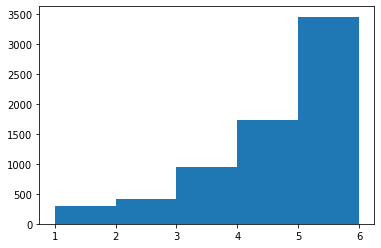

In [36]:
plt.hist(ratings, bins = [1,2,3,4,5,6])
#plt.hist(ratings)

4.1108
1.26412336


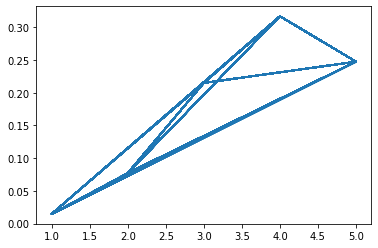

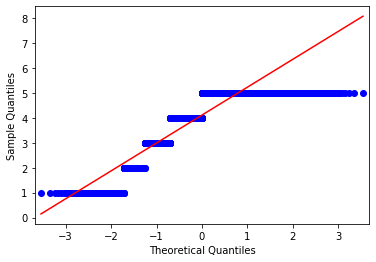

In [48]:
r=np.array(training_data[2])
mean=np.mean(r)
var=np.var(r)
print(mean)
print(var+0.01)
plt.plot(r, stats.norm.pdf(r, mean, var))
plt.show()
qqplot(r, line='s')
plt.show()

In [17]:
#Baseline

base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=baseline)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4dae8cd52da8500c9e3b044aad89f788 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


Inference for Stan model: anon_model_4dae8cd52da8500c9e3b044aad89f788.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      4.05    0.15   0.39   3.25   3.77   4.08   4.34   4.73      7   1.59
truescore[2]      4.03    0.08   0.25    3.6   3.85   4.08   4.21   4.49     10   1.28
truescore[3]      3.94     0.3    0.5   3.32   3.58   3.77   4.24   5.18      3   2.21
truescore[4]      4.05    0.34   0.61   3.11   3.46   4.07   4.56   5.22      3   1.93
truescore[5]      3.59    0.31   0.49   2.59    3.2   3.62    4.0    4.4      3   2.54
truescore[6]      3.58    0.29   0.48   2.88   3.16   3.55   3.97   4.56      3   2.58
truescore[7]      3.53    0.33   0.57   2.45   3.06   3.64   3.95   4.44      3   1.99
truescore[8]      3.79    0.12   0.37   3.08   3.54   3.89   4.06    4.4     10   1.91
truescore[9]      4.25    0.17

In [18]:
la = fit.extract(permuted=False)
print(np.shape(la))

(500, 4, 1324)


In [19]:
#Average goodness and bias
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

3.5039581509372972
0.43047270600558135


In [20]:
#Training RMSE for Baseline
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Baseline",s)

Training RMSE for Baseline 0.7861555336884847


In [21]:
#Testing RMSE for Baseline
s=0
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Baseline",s)

Testing RMSE for Baseline 1.0296234092213912


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


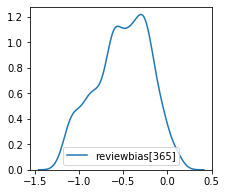

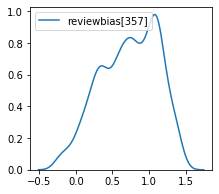

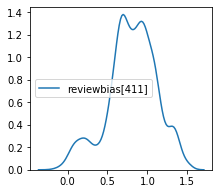

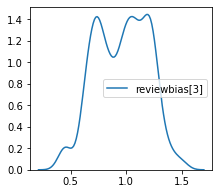

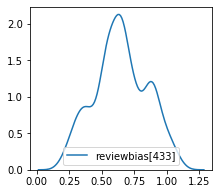

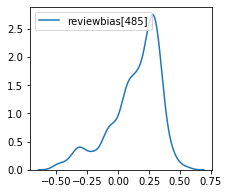

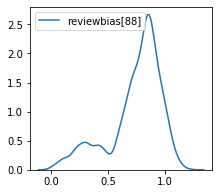

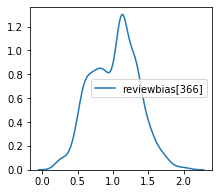

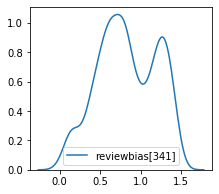

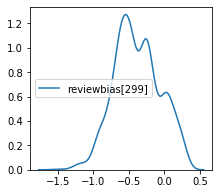

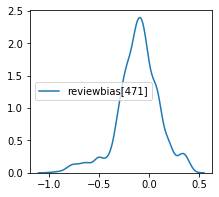

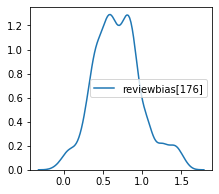

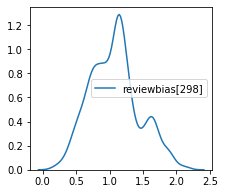

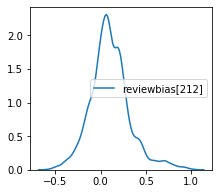

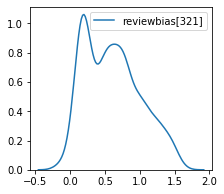

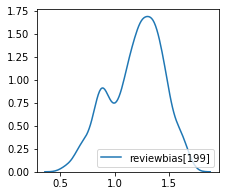

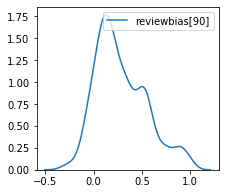

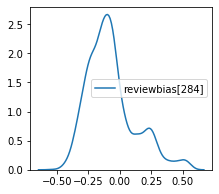

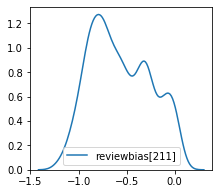

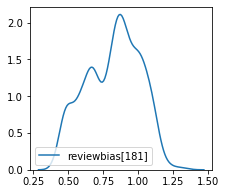

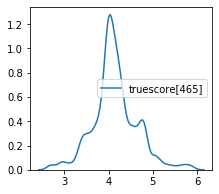

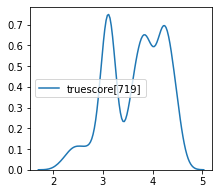

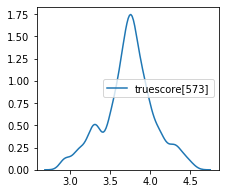

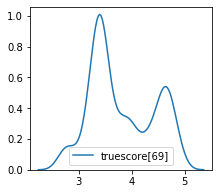

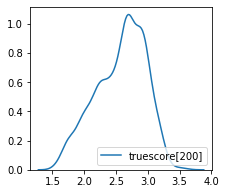

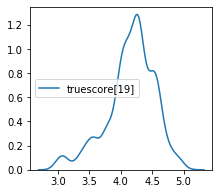

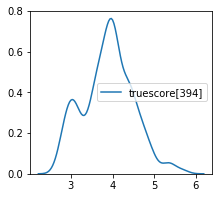

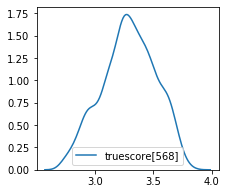

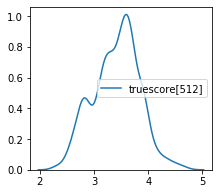

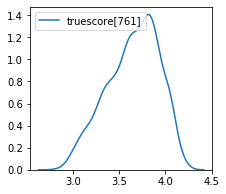

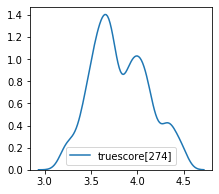

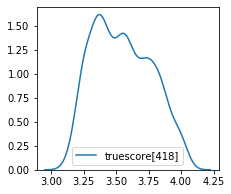

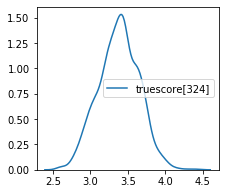

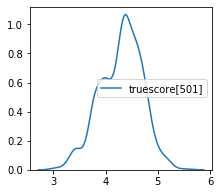

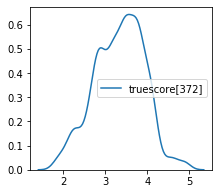

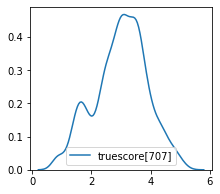

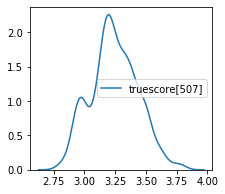

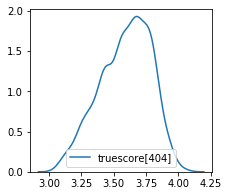

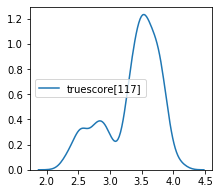

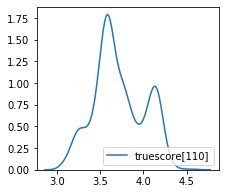

In [24]:
fit_df=fit.to_dataframe()
plot_bias(rusers,fit_df)
plot_goodness(rproducts,fit_df)

In [25]:
#Model 1
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model1)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_43b4b4d7b8c6d300dbe8725b4fa103b0 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_43b4b4d7b8c6d300dbe8725b4fa103b0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]       3.9  9.0e-3    0.4   3.11   3.63    3.9   4.19   4.67   2027    1.0
truescore[2]      4.22  6.0e-3   0.28    3.7   4.03   4.22   4.41   4.79   2120    1.0
truescore[3]       3.8    0.01   0.55   2.71   3.44    3.8   4.18   4.89   2385    1.0
truescore[4]      3.93    0.01   0.53   2.91   3.57   3.93   4.28   4.99   2709    1.0
truescore[5]      3.42  9.6e-3   0.43   2.53   3.14   3.43   3.71   4.24   2036    1.0
truescore[6]      3.66  9.5e-3   0.44    2.8   3.35   3.67   3.95   4.54   2164    1.0
truescore[7]       3.5  9.9e-3   0.47   2.55   3.19   3.51   3.81   4.41   2240    1.0
truescore[8]      3.75  9.2e-3   0.41   2.94   3.46   3.76   4.04   4.52   1992    1.0
truescore[9]      4.05  7.9e-3

In [26]:
#Average goodness and bias
la = fit.extract(permuted=False)
print(np.shape(la))
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

(500, 4, 1324)
3.504655724334079
0.46296773354608567


In [27]:
#Training RMSE for Model 1
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Model 1",s)
s=0

#Testing RMSE for Model 1
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Model 1",s)

Training RMSE for Model 1 0.760764434554889
Testing RMSE for Model 1 1.014690204811622


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


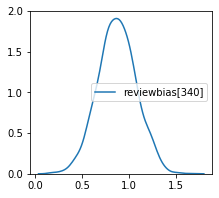

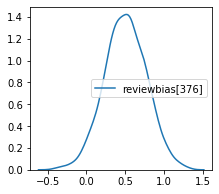

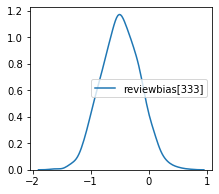

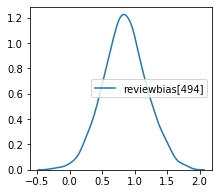

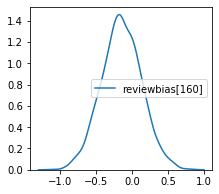

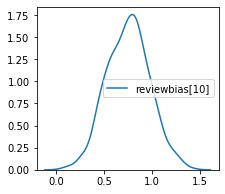

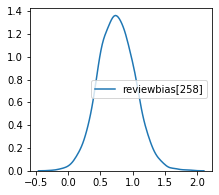

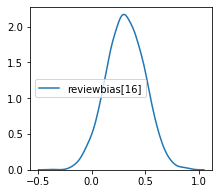

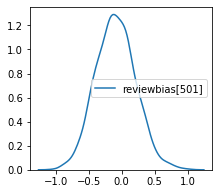

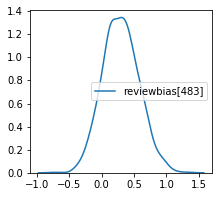

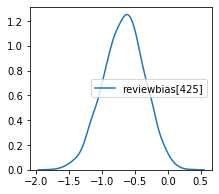

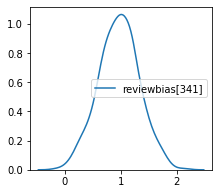

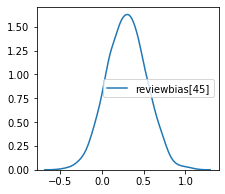

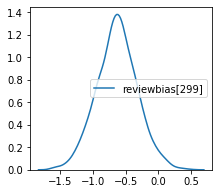

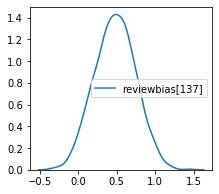

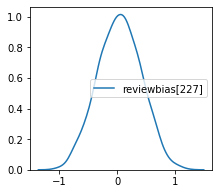

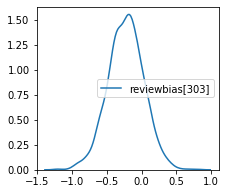

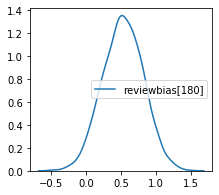

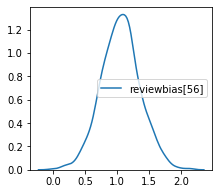

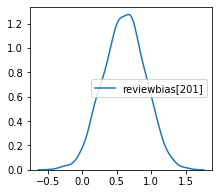

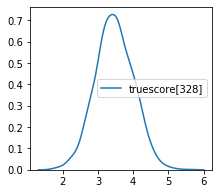

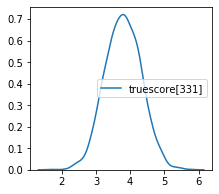

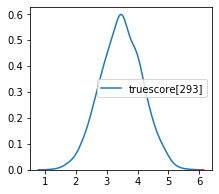

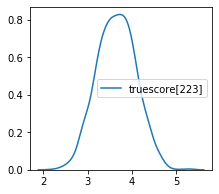

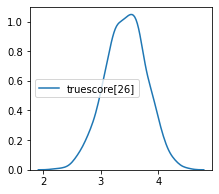

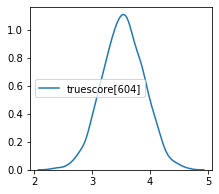

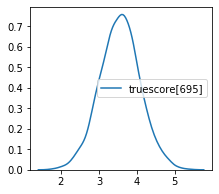

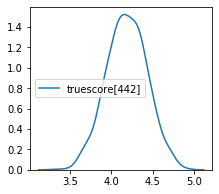

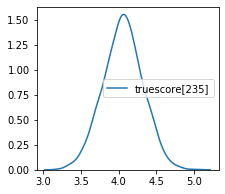

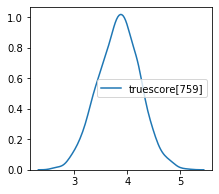

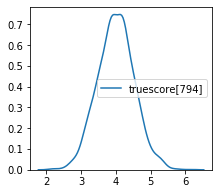

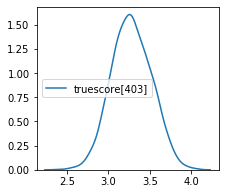

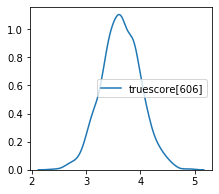

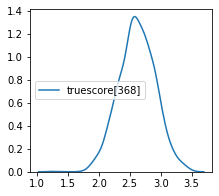

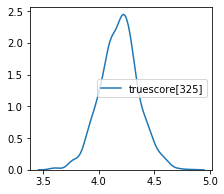

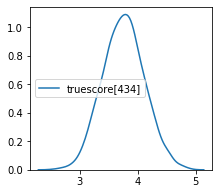

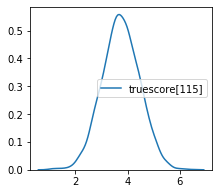

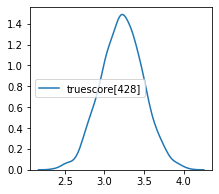

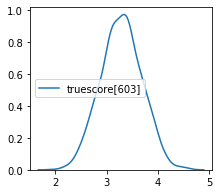

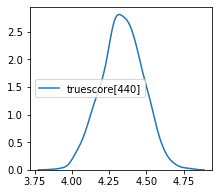

In [28]:
fit_df=fit.to_dataframe()
plot_bias(rusers,fit_df)
plot_goodness(rproducts,fit_df)

In [41]:
#Model 2
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'sentscore':training_data[4], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model2)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e58c704946e5b4e5b32417b37b7901b5 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_e58c704946e5b4e5b32417b37b7901b5.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      4.48  8.6e-3   0.38   3.74   4.23   4.49   4.74   5.23   1925    1.0
truescore[2]      4.74  7.2e-3   0.33   4.06   4.54   4.75   4.96   5.37   2103    1.0
truescore[3]       4.6    0.01    0.5   3.65   4.26    4.6   4.94    5.6   1983    1.0
truescore[4]      4.92    0.01   0.59   3.79    4.5   4.92   5.33   6.09   2065    1.0
truescore[5]      4.32  8.8e-3   0.41   3.51   4.04   4.32   4.61    5.1   2122    1.0
truescore[6]      4.23  8.1e-3   0.39   3.46   3.97   4.23   4.49   5.01   2346    1.0
truescore[7]      3.85    0.01    0.5    2.9   3.51   3.85   4.18   4.83   2142    1.0
truescore[8]      4.31  8.2e-3   0.38   3.58   4.05   4.32   4.57   5.07   2153    1.0
truescore[9]      4.67  9.9e-3

In [42]:
#Average goodness and bias
la = fit.extract(permuted=False)
print(np.shape(la))
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

(500, 4, 1324)
4.108090609333759
0.0011066624645557992


In [43]:
#Training RMSE for Model 2
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Model 2",s)
s=0

#Testing RMSE for Model 1
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Model 2",s)

Training RMSE for Model 2 0.7764544144297164
Testing RMSE for Model 2 0.9787040161037396


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


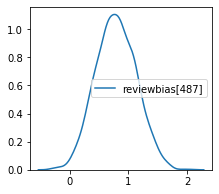

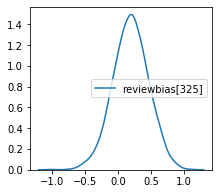

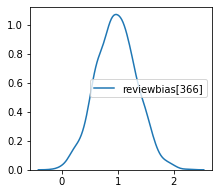

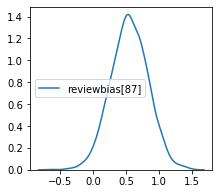

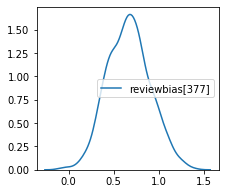

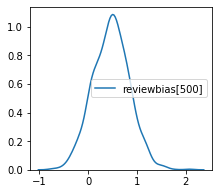

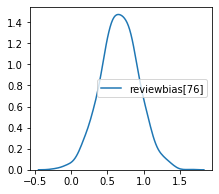

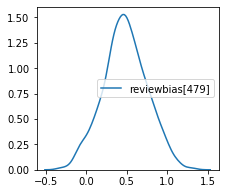

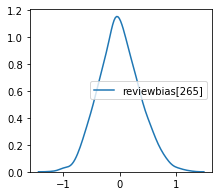

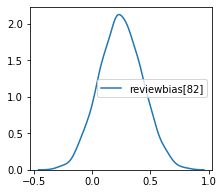

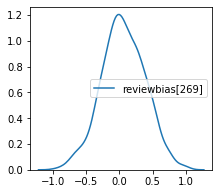

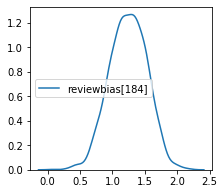

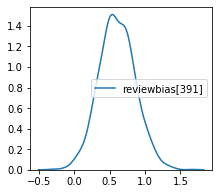

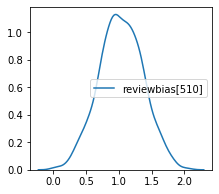

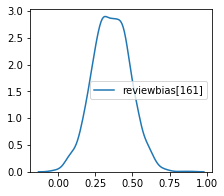

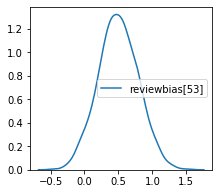

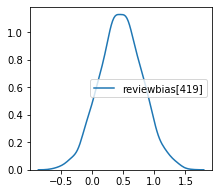

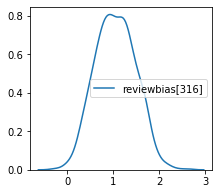

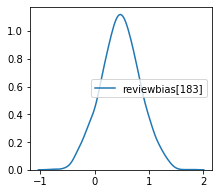

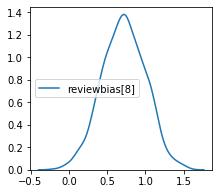

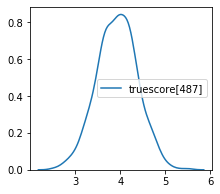

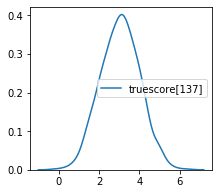

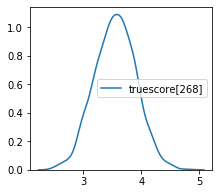

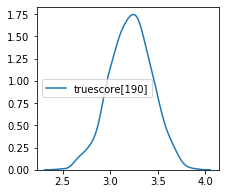

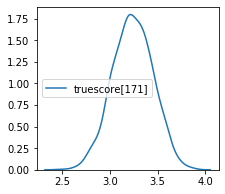

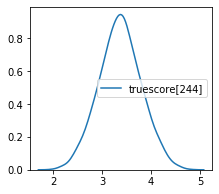

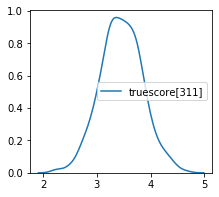

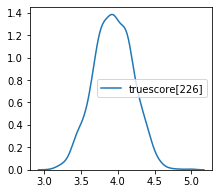

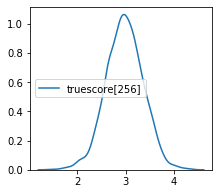

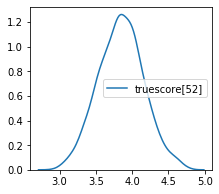

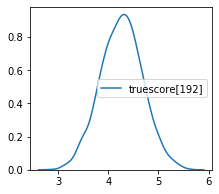

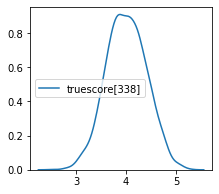

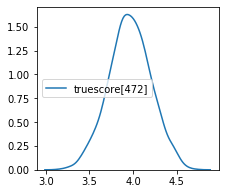

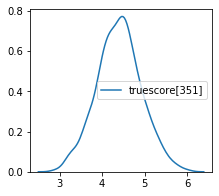

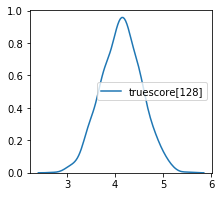

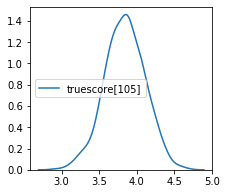

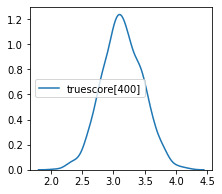

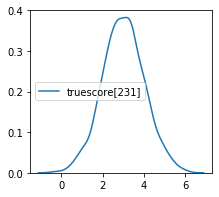

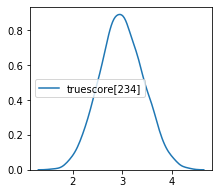

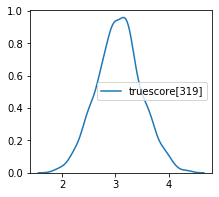

In [224]:
fit_df=fit.to_dataframe()
plot_bias(rusers,fit_df)
plot_goodness(rproducts,fit_df)

In [225]:
#Model 3
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'helpfulness':training_data[3], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model3)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a58fdecda7b34ec2cd922c960edf3761 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_a58fdecda7b34ec2cd922c960edf3761.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      4.79    0.05   0.21   4.23   4.68   4.81   4.94   5.11     21   1.06
truescore[2]      4.59    0.08   0.32   3.86   4.43   4.59   4.79    5.2     16   1.44
truescore[3]      4.49    0.26   0.45   3.63   4.17   4.48   4.93   5.16      3   1.95
truescore[4]      4.69    0.14   0.32    4.1   4.42   4.69   4.89   5.41      5   1.42
truescore[5]      4.35    0.13   0.35   3.63   4.08   4.43   4.61    4.9      7    1.3
truescore[6]      4.83    0.07   0.33   4.08   4.63   4.86   5.04   5.44     21   1.15
truescore[7]      3.96    0.48   0.77   2.96   3.31   3.72   4.52    5.6      3   2.41
truescore[8]      4.04     0.1   0.34   3.29   3.85   4.04   4.28   4.66     12   1.43
truescore[9]      4.23    0.12

In [31]:
#Average goodness and bias
la = fit.extract(permuted=False)
print(np.shape(la))
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

(500, 4, 1324)
4.122492079179876
0.0016712920045070293


In [32]:
#Training RMSE for Model 3
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Model 3",s)
s=0

#Testing RMSE for Model 3
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Model 3",s)

Training RMSE for Model 1 0.7643849086302908
Testing RMSE for Model 1 1.014407092997409


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


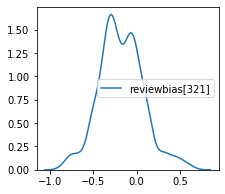

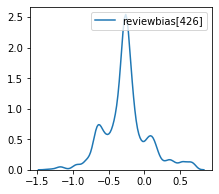

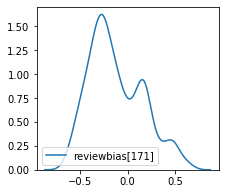

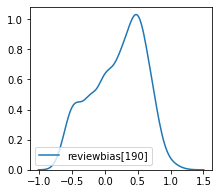

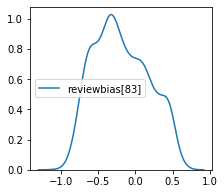

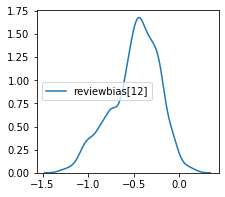

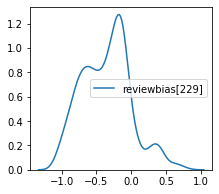

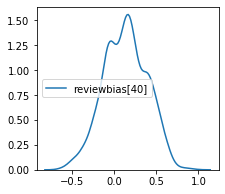

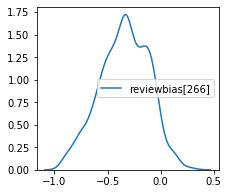

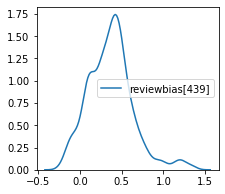

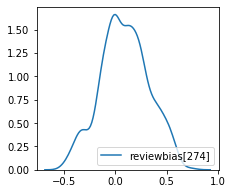

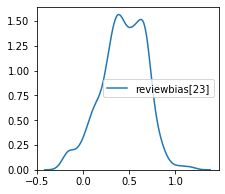

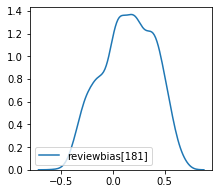

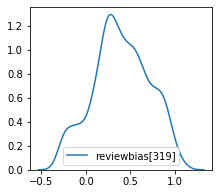

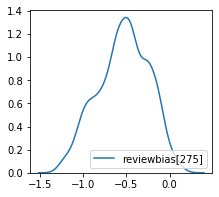

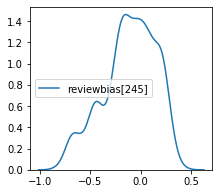

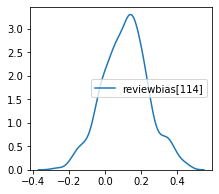

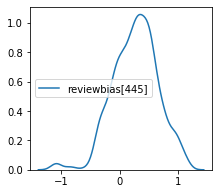

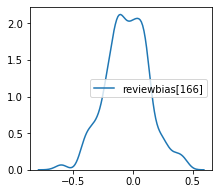

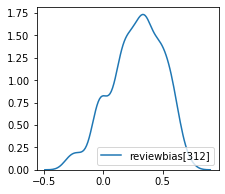

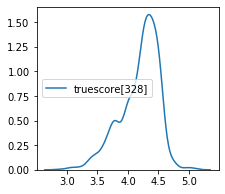

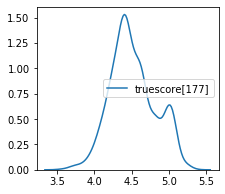

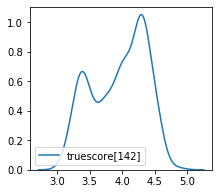

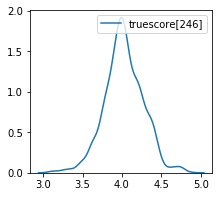

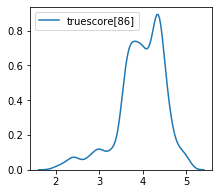

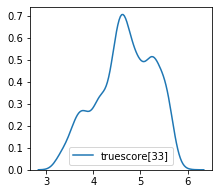

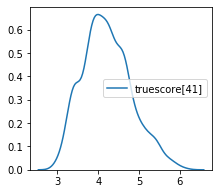

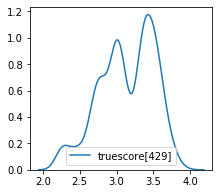

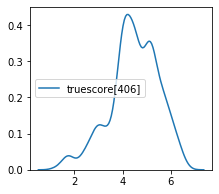

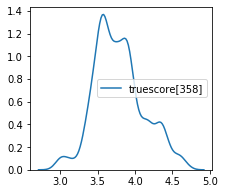

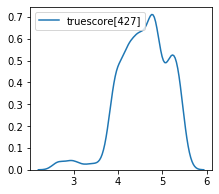

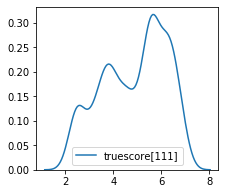

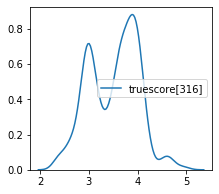

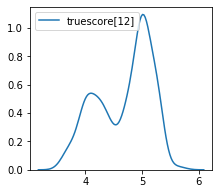

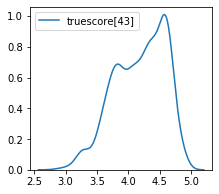

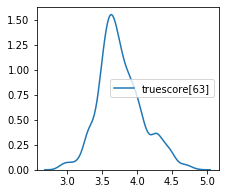

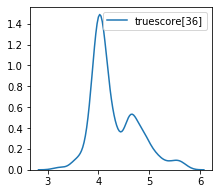

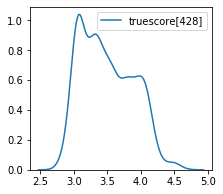

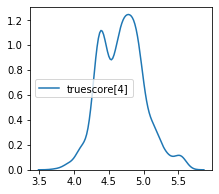

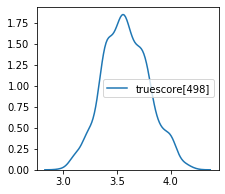

In [228]:
fit_df=fit.to_dataframe()
plot_bias(rusers,fit_df)
plot_goodness(rproducts,fit_df)

In [37]:
#Model 4
base_data = {'I': 810, 'N': 5000, 'J':511, 'scores':training_data[2], 'helpfulness':training_data[3], 'reviewerID':training_data[0], 'prodID':training_data[1]}

sm = pystan.StanModel(model_code=model3)

fit = sm.sampling(data=base_data, iter=1000, chains=4)

print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_472c38b06f4dc73b2bb8f0dfd5b8d443 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_472c38b06f4dc73b2bb8f0dfd5b8d443.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
truescore[1]      4.53  8.8e-3    0.4   3.76   4.27   4.51   4.79   5.29   2025    1.0
truescore[2]      4.81  5.9e-3   0.31    4.2   4.61   4.81   5.02    5.4   2735    1.0
truescore[3]      4.58  9.9e-3   0.54   3.55   4.21   4.56   4.95   5.66   3031    1.0
truescore[4]      4.88    0.01   0.62   3.65   4.46   4.88   5.31   6.08   3240    1.0
truescore[5]      4.31  8.2e-3   0.41   3.47   4.04   4.31   4.59   5.13   2568    1.0
truescore[6]      4.16  7.7e-3   0.38   3.41   3.91   4.15    4.4   4.89   2408    1.0
truescore[7]      3.84 10.0e-3   0.47   2.91   3.52   3.83   4.16   4.77   2251    1.0
truescore[8]      4.17  7.9e-3    0.4   3.39   3.91   4.18   4.45   4.95   2553    1.0
truescore[9]      4.64  9.6e-3

In [38]:
#Average goodness and bias
la = fit.extract(permuted=False)
print(np.shape(la))
goodness=[]
bias=[]
gp=0
bu=0
for k in range(len(rproducts)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][k]
    goodness.append(a/2000)
    gp+=(a/2000)
for p in range(k+1,k+1+len(rusers)):
    a=0
    for i in range(np.shape(la)[0]):
        for j in range(np.shape(la)[1]):
            a+=la[i][j][p]
    bias.append(a/2000)
    bu+=(a/2000)
print(gp/len(rproducts))
print(bu/511)

(500, 4, 1324)
4.103124217148879
-0.003879726999048805


In [39]:
#Training RMSE for Model 3
s=0
for r in range(len(training_data[0])):
    rindex=training_data[0][r]-1
    pindex=training_data[1][r]-1
    a=(training_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/5000)**(0.5)
print("Training RMSE for Model 4",s)
s=0

#Testing RMSE for Model 3
for r in range(len(test_data[0])):
    rindex=test_data[0][r]-1
    pindex=test_data[1][r]-1
    a=(test_data[2][r]-goodness[pindex]-bias[rindex])**2
    s+=a
s=(s/len(test_data[0]))**(0.5)
print("Testing RMSE for Model 4",s)

Training RMSE for Model 1 0.7762844706446306
Testing RMSE for Model 1 0.9788495361376819
